In [1]:
import pandas as pd  # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns  # type: ignore
import scipy.fftpack # type: ignore
from glob import glob
import librosa
import librosa.display as lplt  # type: ignore
import IPython.display as ipd  # type: ignore
import os
import tensorflow as tf  # type: ignore
import tensorflow_io as tfio  # type: ignore
import pickle
import numpy as np  # type: ignore 
import matplotlib.pyplot as plt # type: ignore 
import seaborn as sns  # type: ignore 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
def load_function(filename):
  fiel_content= tf.io.read_file(filename)
  wav , sample_rate = tf.audio.decode_wav(fiel_content , desired_channels=1)
  wav = tf.squeeze(wav , axis= -1)
  sample_rate = tf.cast(sample_rate , dtype= tf.int64)
  wav = tfio.audio.resample(wav , rate_in=sample_rate , rate_out=1600)
  return wav


def preprocess(file_path , label ):
  wav = load_function(file_path )
  wav = wav[:6000]
  zero_padding = tf.zeros([6000] - tf.shape(wav),dtype=tf.float32 )
  wav = tf.concat([zero_padding,wav],0)
  spectrogram = tf.signal.stft(wav , frame_length=320 , frame_step=32)
  spectrogram = tf.abs(spectrogram)
  spectrogram = tf.expand_dims(spectrogram, axis = 2)
  return spectrogram , label

In [3]:
trainig_real_audio = 'data/for-norm/for-norm/training/real'
trainig_fake_audio = 'data/for-norm/for-norm/training/fake'

testing_real_audio = 'data/for-norm/for-norm/testing/real'
testing_fake_audio = 'data/for-norm/for-norm/testing/fake'

validation_real_audio = 'data/for-norm/for-norm/validation/real'
validation_fake_audio = 'data/for-norm/for-norm/validation/fake'


In [4]:
TRA = tf.data.Dataset.list_files(trainig_real_audio +'/*.wav')
TFA = tf.data.Dataset.list_files(trainig_fake_audio +'/*.wav')

TESTRA = tf.data.Dataset.list_files(testing_real_audio +'/*.wav')
TESTFA = tf.data.Dataset.list_files(testing_fake_audio +'/*.wav')

VRA = tf.data.Dataset.list_files(validation_real_audio +'/*.wav')
VFA = tf.data.Dataset.list_files(validation_fake_audio +'/*.wav')


In [5]:
Treal = tf.data.Dataset.zip((TRA,tf.data.Dataset.from_tensor_slices(tf.zeros(len(TRA)))))
Tfake = tf.data.Dataset.zip((TFA,tf.data.Dataset.from_tensor_slices(tf.ones(len(TFA)))))

TestReal = tf.data.Dataset.zip((TESTRA,tf.data.Dataset.from_tensor_slices(tf.zeros(len(TESTRA)))))
TestFake = tf.data.Dataset.zip((TESTFA,tf.data.Dataset.from_tensor_slices(tf.ones(len(TESTFA )))))

Vreal = tf.data.Dataset.zip((VRA,tf.data.Dataset.from_tensor_slices(tf.zeros(len(VRA)))))
Vfake = tf.data.Dataset.zip((VFA,tf.data.Dataset.from_tensor_slices(tf.ones(len(VFA)))))

RealAudio = Treal.concatenate(TestReal.concatenate(Vreal))
FakeAudio = Tfake.concatenate(TestFake.concatenate(Vfake))

data = RealAudio.concatenate(FakeAudio)

In [6]:
data.shuffle(1000000).as_numpy_iterator().next()

(b'data\\for-norm\\for-norm\\training\\fake\\file25458.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav',
 1.0)

In [8]:
num_real_samples = len(list(RealAudio.as_numpy_iterator()))
num_fake_samples = len(list(FakeAudio.as_numpy_iterator()))

print(f'Number of RealAudio samples: {num_real_samples}')
print(f'Number of FakeAudio samples: {num_fake_samples}')

Number of RealAudio samples: 34605
Number of FakeAudio samples: 36819


In [9]:
if num_real_samples < num_fake_samples:
    num_samples_diff = num_fake_samples - num_real_samples
    FakeAudio = FakeAudio.take(num_fake_samples - num_samples_diff)
elif num_real_samples > num_fake_samples:
    num_samples_diff = num_real_samples - num_fake_samples
    RealAudio = RealAudio.take(num_real_samples - num_samples_diff)

# Count the number of samples again to make sure the dataset is  balance
num_real_samples = len(list(RealAudio.as_numpy_iterator()))
num_fake_samples = len(list(FakeAudio.as_numpy_iterator()))

print(f'Number of RealAudio samples after balancing: {num_real_samples}')
print(f'Number of FakeAudio samples after balancing: {num_fake_samples}')

Number of RealAudio samples after balancing: 34605
Number of FakeAudio samples after balancing: 34605


In [10]:
data = RealAudio.concatenate(FakeAudio)

In [11]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=100000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
# calcute 70% of the data we have , and define how many remain 
x = len(data)*0.7
y = len(data)
z = y - x
print( "all the data set : ",y,"\n70% of the data set :", x , "\nthe remaine:", z )

all the data set :  4326 
70% of the data set : 3028.2 
the remaine: 1297.8000000000002


In [13]:
train = data.take(3029)
test = data.skip(3029).take(1297)

In [21]:
samples , label = train.as_numpy_iterator().next()
print("the shape of the sample" , samples.shape)
label

the shape of the sample (16, 178, 257, 1)


array([0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
      dtype=float32)

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from keras.layers import TimeDistributed

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(178, 257, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(TimeDistributed(Flatten()))  # Add TimeDistributed to apply Flatten to each time step
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Adjust for binary or multi-class

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 255, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 62, 64)       0         
 2D)                                                             
                                                                 
 time_distributed (TimeDistr  (None, 43, 3968)         0         
 ibuted)                                                         
                                                        

In [ ]:
CNN_LSTM_model = model.fit(train, epochs=4, validation_data=test)

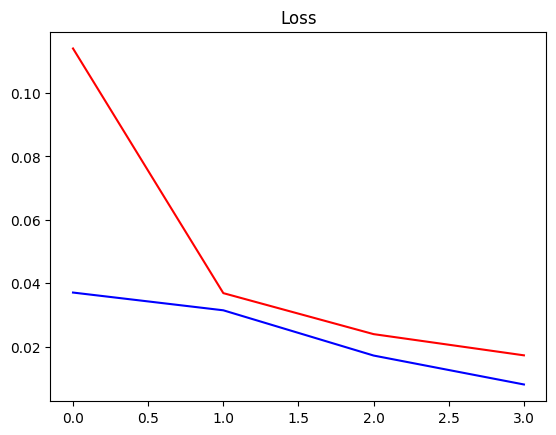

In [25]:
plt.title('Loss')
plt.plot(CNN_LSTM_model.history['loss'], 'r')
plt.plot(CNN_LSTM_model.history['val_loss'], 'b')
plt.show()

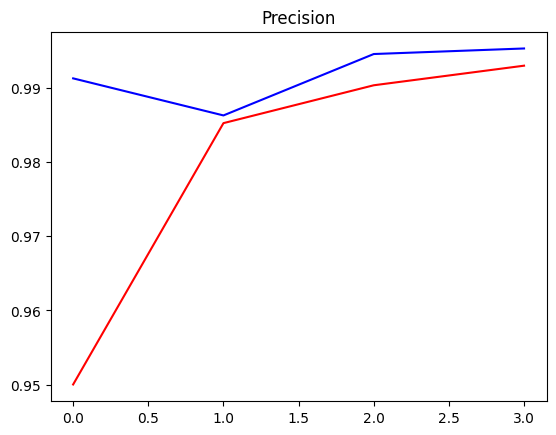

In [26]:
plt.title('Precision')
plt.plot(CNN_LSTM_model.history['precision'], 'r')
plt.plot(CNN_LSTM_model.history['val_precision'], 'b')
plt.show()

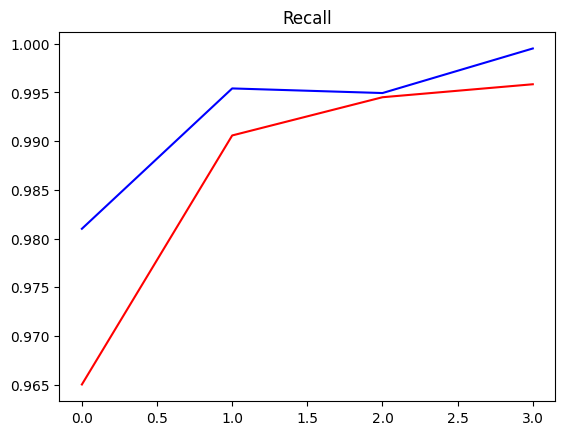

In [27]:
plt.title('Recall')
plt.plot(CNN_LSTM_model.history['recall'], 'r')
plt.plot(CNN_LSTM_model.history['val_recall'], 'b')
plt.show()

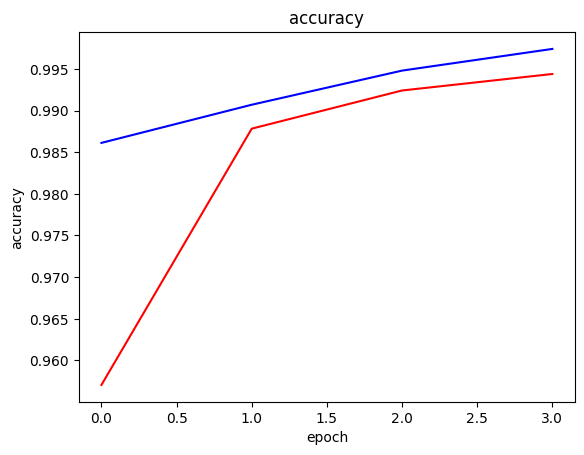

In [28]:
plt.title('accuracy')
plt.plot(CNN_LSTM_model.history['accuracy'], 'r')
plt.plot(CNN_LSTM_model.history['val_accuracy'], 'b')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [14]:
x_test , y_test = test.as_numpy_iterator().next()

In [30]:
predictionForAudio =  model.predict(x_test)

1/1 [==============================] - 6s 6s/step


In [31]:
predictionForAudio

array([[9.9978328e-01],
       [2.7641107e-07],
       [1.8336278e-06],
       [9.9981284e-01],
       [9.9968934e-01],
       [5.9467798e-06],
       [9.9573936e-07],
       [1.8927680e-06],
       [3.8743959e-04],
       [4.0814763e-07],
       [9.9965841e-01],
       [4.1011882e-07],
       [1.5342892e-04],
       [4.8838251e-07],
       [9.9958527e-01],
       [9.9809760e-01]], dtype=float32)

In [32]:
predictionForAudio = [ 1 if prediction > 0.5 else  0 for prediction in predictionForAudio]

In [33]:
tf.math.reduce_sum(predictionForAudio)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [34]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [35]:
predictionForAudio

[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1]

In [36]:
y_test.astype(int)

array([1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1])

In [37]:
import pickle

# Save the model to a file
with open('trained_model.pkl', 'wb') as file:
    pickle.dump(model, file)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...metrics\precision
......vars
.........0
.........1
...metrics\recall
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2

In [15]:
import pickle 
with open('trained_model.pkl', 'rb') as file:
    CNN_LSTM = pickle.load(file)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2024-04-23 19:58:58         5228
metadata.json                                  2024-04-23 19:58:58           64
variables.h5                                   2024-04-23 19:58:58     10248328
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\conv2d
......vars
.........0
.........1
...layers\conv2d_1
......vars
.........0
.........1
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\lstm
......vars
...layers\lstm\cell
......vars
.........0
.........1
.........2
...layers\lstm_1
......vars
...layers\lstm_1\cell
......vars
.........0
.........1
.........2
...layers\max_pooling2d
......vars
...layers\max_pooling2d_1
......vars
...layers\time_distributed
......vars
...layers\time_distributed\layer
......vars
...metrics\mean
......vars
.........0
.......

In [16]:
y_pred = CNN_LSTM.predict(x_test)

1/1 [==============================] - 7s 7s/step


In [22]:
threshold = 0.9 # Adjust threshold as needed

# Convert probabilities to binary labels
y_pred_binary = (y_pred > threshold).astype(int)

# Now calculate classification metrics with binary labels
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0


In [24]:
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[9 0]
 [0 7]]


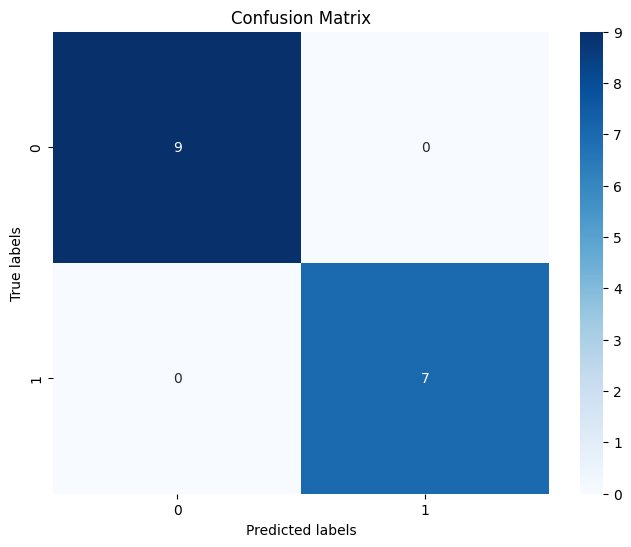

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()